In [ ]:
from scipy.special import expit as sigmoid, logit as inverse_sigmoid #Extracting individual predicted values
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from collections import Counter 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import cv
import xgboost as xgb
import os
import shap #Explainable model

#Define the path
path=os.getcwd()


## All Models Log Loss Evaluation Metrics

In [5]:
import plotly
import kaleido
import plotly.express as px
import plotly.graph_objects as go


df1 = pd.read_excel("../model_graphs/logloss1.xlsx")
df2 = df1.iloc[:,1:]
colors = [ 'red', 'blue', 'green']

fig = go.Figure()
for i, col in enumerate(df2):
    fig.add_traces(go.Scatter(x=df1.Model, y = df2[col].values,
                              mode = 'markers',
                              name = col,
                              marker=dict(color=colors[i])))
fig.update_traces(marker_size=15)

fig.update_layout( scattergap=0.75,
    plot_bgcolor = "white")

fig.update_layout(title={
    'text': "<b>Evaluation Metrics for AIV Models </b>",
    'y':0.78,
    'x':0.45,
    'xanchor': 'center',
    'yanchor': 'top'})#,
    #width=650, height=400)
fig.update_xaxes(title_text='Model', showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(title_text='Logloss', showline=True, linewidth=2, linecolor='black', mirror=True)
fig.write_image("../images/mlogloss_all_models.png", width=600, height=350, scale=2)
print("\nDone......\n")


Done......



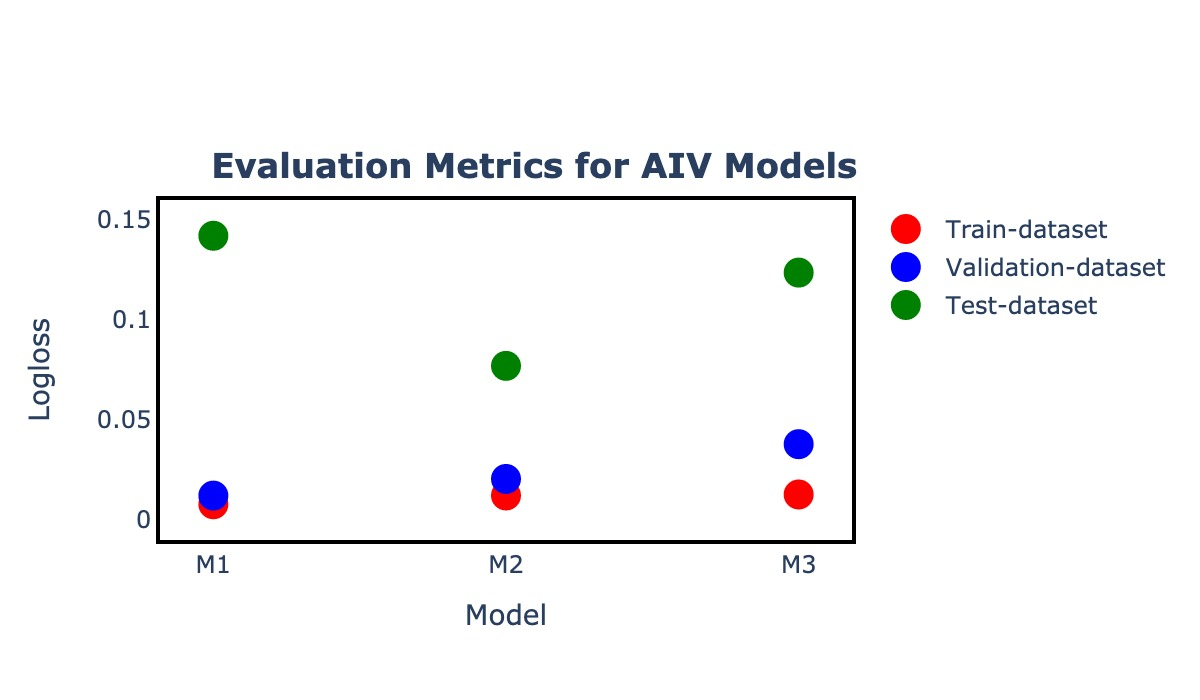

In [6]:
#View the Image inline
from IPython.display import Image
img_bytes = fig.to_image(format="jpg", width=600, height=350, scale=2,  engine="kaleido")
Image(img_bytes)


# Model one SHAP Analysis   (No Wild birds used as features)

In [8]:
#Load the model
bst1 = xgb.Booster({'nthread': 4}) #init model
bst1.load_model('../model1/model1xgb.model')

In [ ]:
#Load Train and Test files
train_df = pd.read_excel("../model1/eighty_twenty/m1train.xlsx")
test_df = pd.read_excel("../model1/eighty_twenty/m1test.xlsx")
X_train = train_df.iloc[:,3:-1] #Training
y_train = train_df.iloc[:,-1:]

#Test
X_test = test_df.iloc[:,3:-1]
X_test_raw = test_df.iloc[:,3:-1]
y_test = test_df.iloc[:,-1:]
y_test_raw = test_df.iloc[:,-1:]

print("\nDone Loading Data Files.........\n")

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



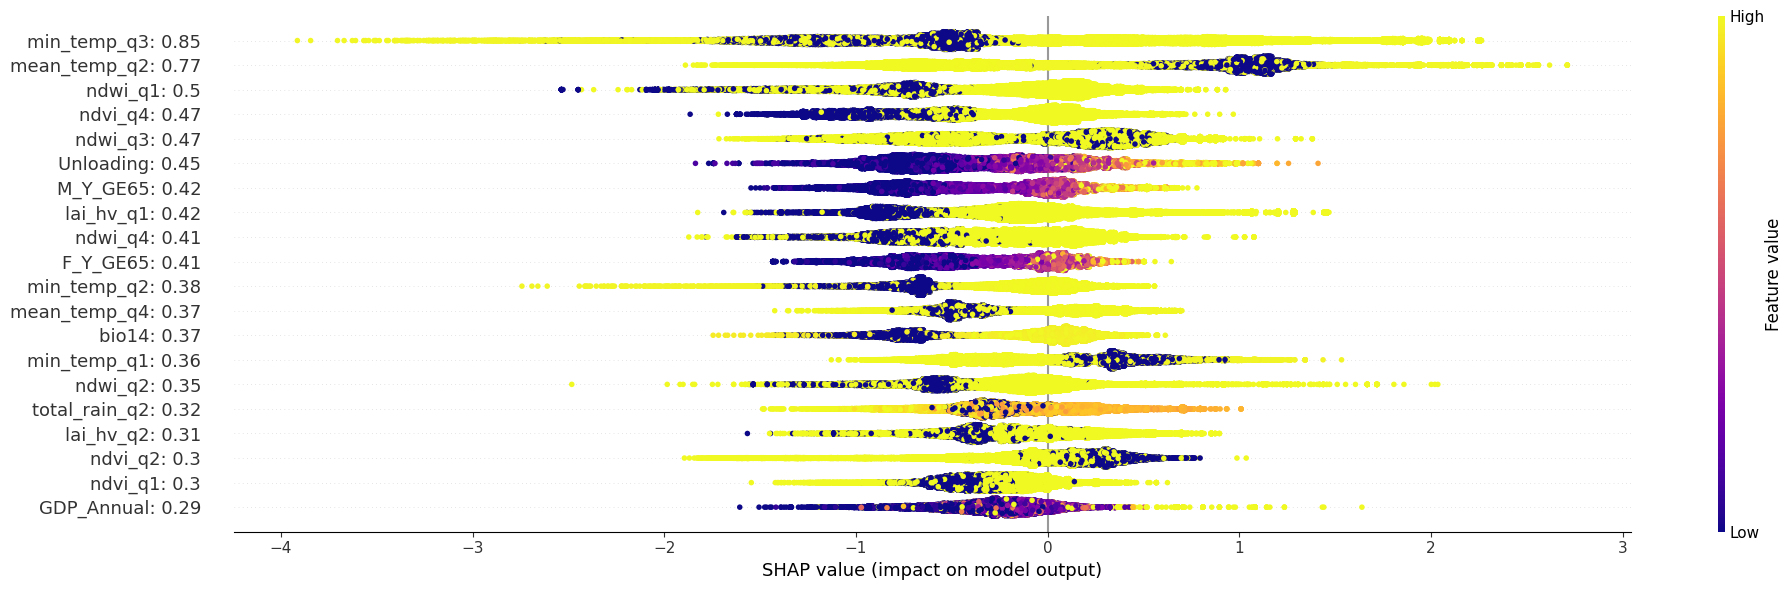

In [11]:
#Run SHAP model
explainer = shap.TreeExplainer(bst1)
shap_values = explainer.shap_values(X_train)
#print(shap_values)
feature_names = [a + ": " + str(b) for a,b in zip(X_train.columns, np.abs(shap_values).mean(0).round(2))]
shap.summary_plot(shap_values, 
                  features=X_train, 
                #cmap = plt.get_cmap("summer"),
                  cmap = plt.get_cmap("plasma"),
                  feature_names=feature_names,
                  show=False
                )
plt.gcf().set_size_inches(20,6)
plt.tight_layout()
plt.show()

####  M1 Bar Plot


 Done Processing....



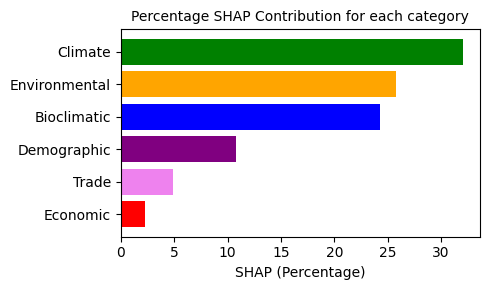

In [12]:
df = pd.read_excel("../model_graphs/model1_bargraph.xlsx")
x = df["Variables"]
y = df["Percentage"]
color=["green", "orange", "blue", "purple", "violet", "red"]
plt.figure(figsize=(5,3))
plt.title("Percentage SHAP Contribution for each category", fontsize=10)
plt.xlabel("SHAP (Percentage)")
#plt.ylabel("Feature Category")
revcolor = color[::-1]
plt.barh(x,y, color=revcolor)
plt.tight_layout()
plt.savefig("../images/model1_shapCat.png", dpi=500)

print("\n Done Processing....\n")

### Class Contribution

In [27]:
def global_class_contribution(model, X, name):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    print("Model Name....", name)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
    return feature_importance.to_excel("{}_class_contribution.xlsx".format(name))
global_class_contribution(bst1, X_train, "bst1")
print("\nDone Processing......\n")

Model Name.... bst1

Done Processing......



# Model Two SHAP Analysis  (Wild Birds used as features)

In [2]:
#Load M2 Retuned Model
bst2_retuned = xgb.Booster({'nthread': 4}) #init model
bst2_retuned.load_model('../model2/model2xgb.model')
print("Successfully loaded the models.....")

Successfully loaded the models.....


In [ ]:
#Load Train and Test Excel files
train_df2 = pd.read_excel("../model2/eighty_twenty/m2train.xlsx")
test_df2 = pd.read_excel("../model2/eighty_twenty/m2test.xlsx")
X_train2 = train_df2.iloc[:,3:] #Training
y_train2 = train_df2.iloc[:,2:3]

X_test2 = test_df2.iloc[:,3:]
X_test2_mat = xgb.DMatrix(X_test2)
X_test_raw2 = test_df2.iloc[:,3:]
y_test2 = test_df2.iloc[:,2:3]
y_test_raw2 = test_df2.iloc[:,2:3]

print("Finished Loading data....")


/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



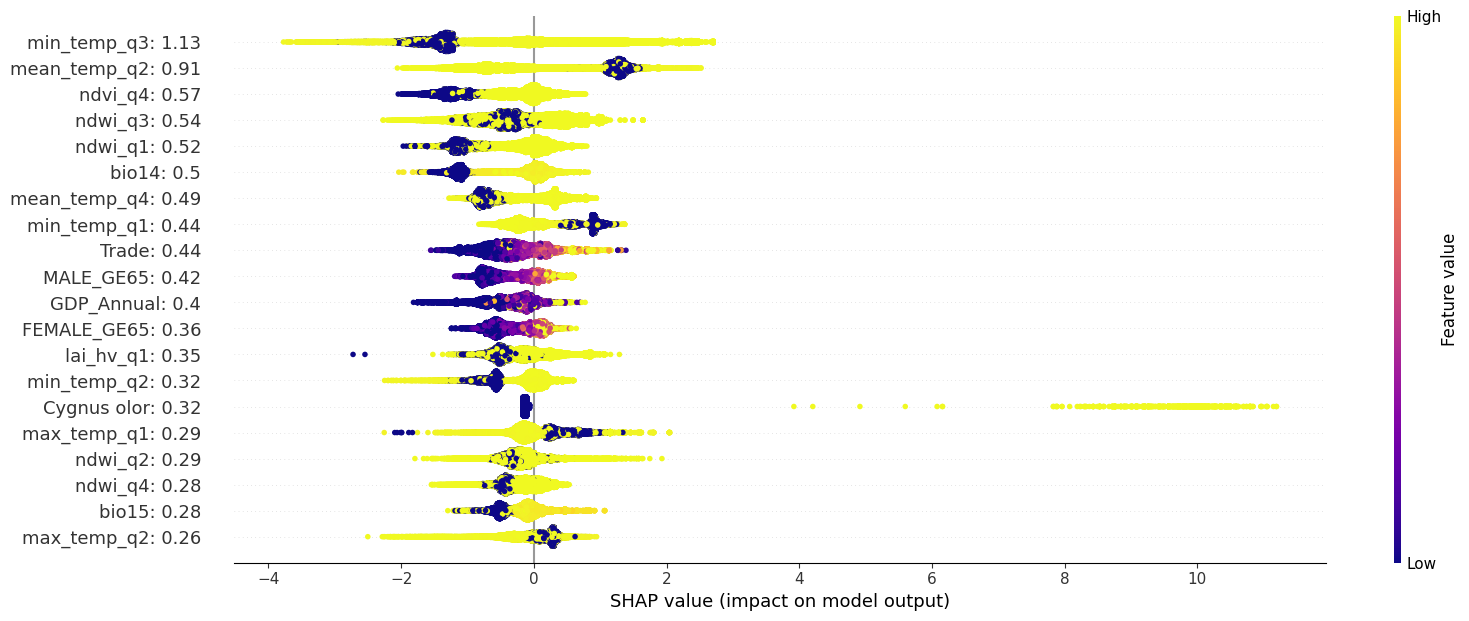

In [19]:
#Retuned New Model
explainer = shap.TreeExplainer(bst2_retuned)
shap_values2 = explainer.shap_values(X_train2)
#print(shap_values)
feature_names = [a + ": " + str(b) for a,b in zip(X_train2.columns, np.abs(shap_values2).mean(0).round(2))]
shap.summary_plot(shap_values2, 
                  features=X_train2, 
                #cmap = plt.get_cmap("summer"),
                  cmap = plt.get_cmap("plasma"),
                  feature_names=feature_names,
                  show=False
                )
plt.gcf().set_size_inches(20,6)
plt.show()

### Class Contribution

In [28]:

global_class_contribution(bst2_retuned, X_train2, "bst2")
print("\nDone Processing....")

Model Name.... bst2
/Users/michaelrogo/software/cli_he_code/paper/nature_coms/coms/analysis


#### M2 Bar Plot


Done processing....



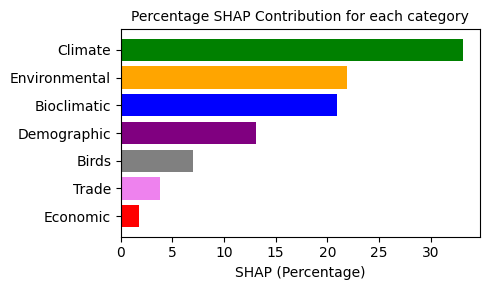

In [29]:
df = pd.read_excel("../model_graphs/model2_bargraph.xlsx")
x = df["Variables"]
y = df["Percentage"]
color=["green", "orange", "blue", "purple", "gray", "violet", "red"]
revcolor = color[::-1]
plt.figure(figsize=(5,3))
plt.title("Percentage SHAP Contribution for each category",fontsize=10)
plt.xlabel("SHAP (Percentage)")
#plt.ylabel("Feature Category")
plt.barh(x,y, color=revcolor)
#plt.savefig("model2_bargraph.png")
plt.tight_layout()
plt.savefig("../images/model2_shapCat.png", dpi=500)
print("\nDone processing....\n")

## Plot XGBoost Model

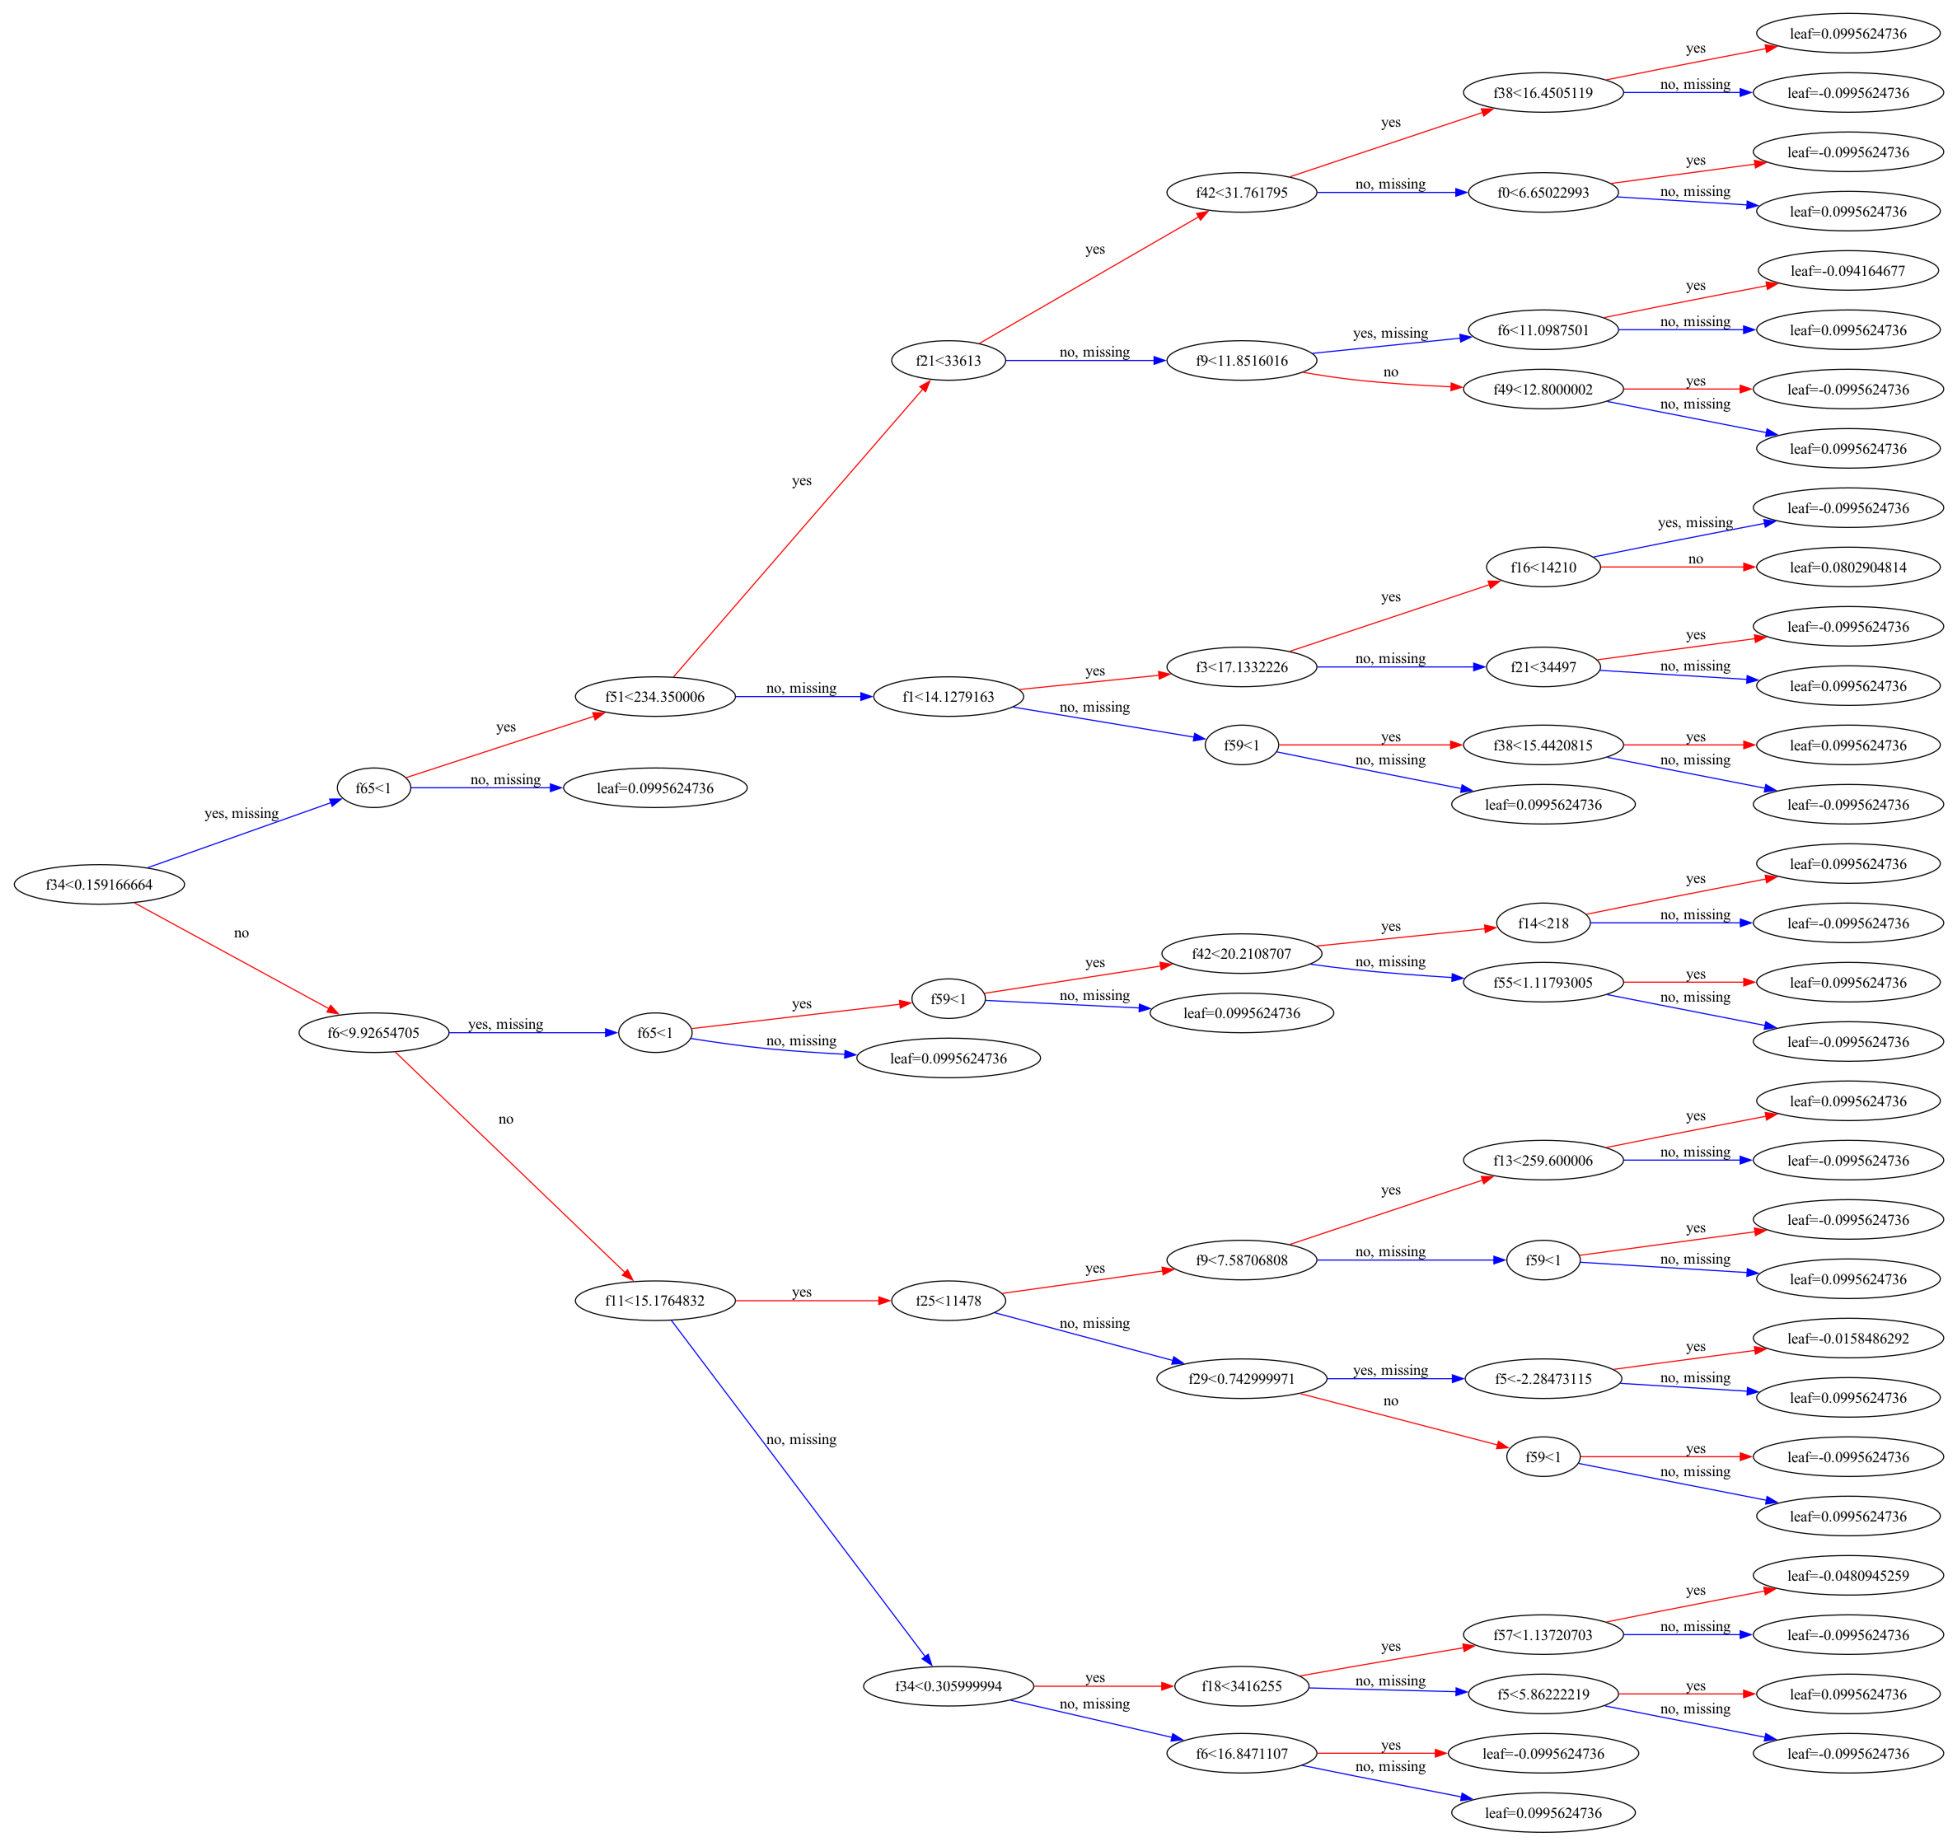

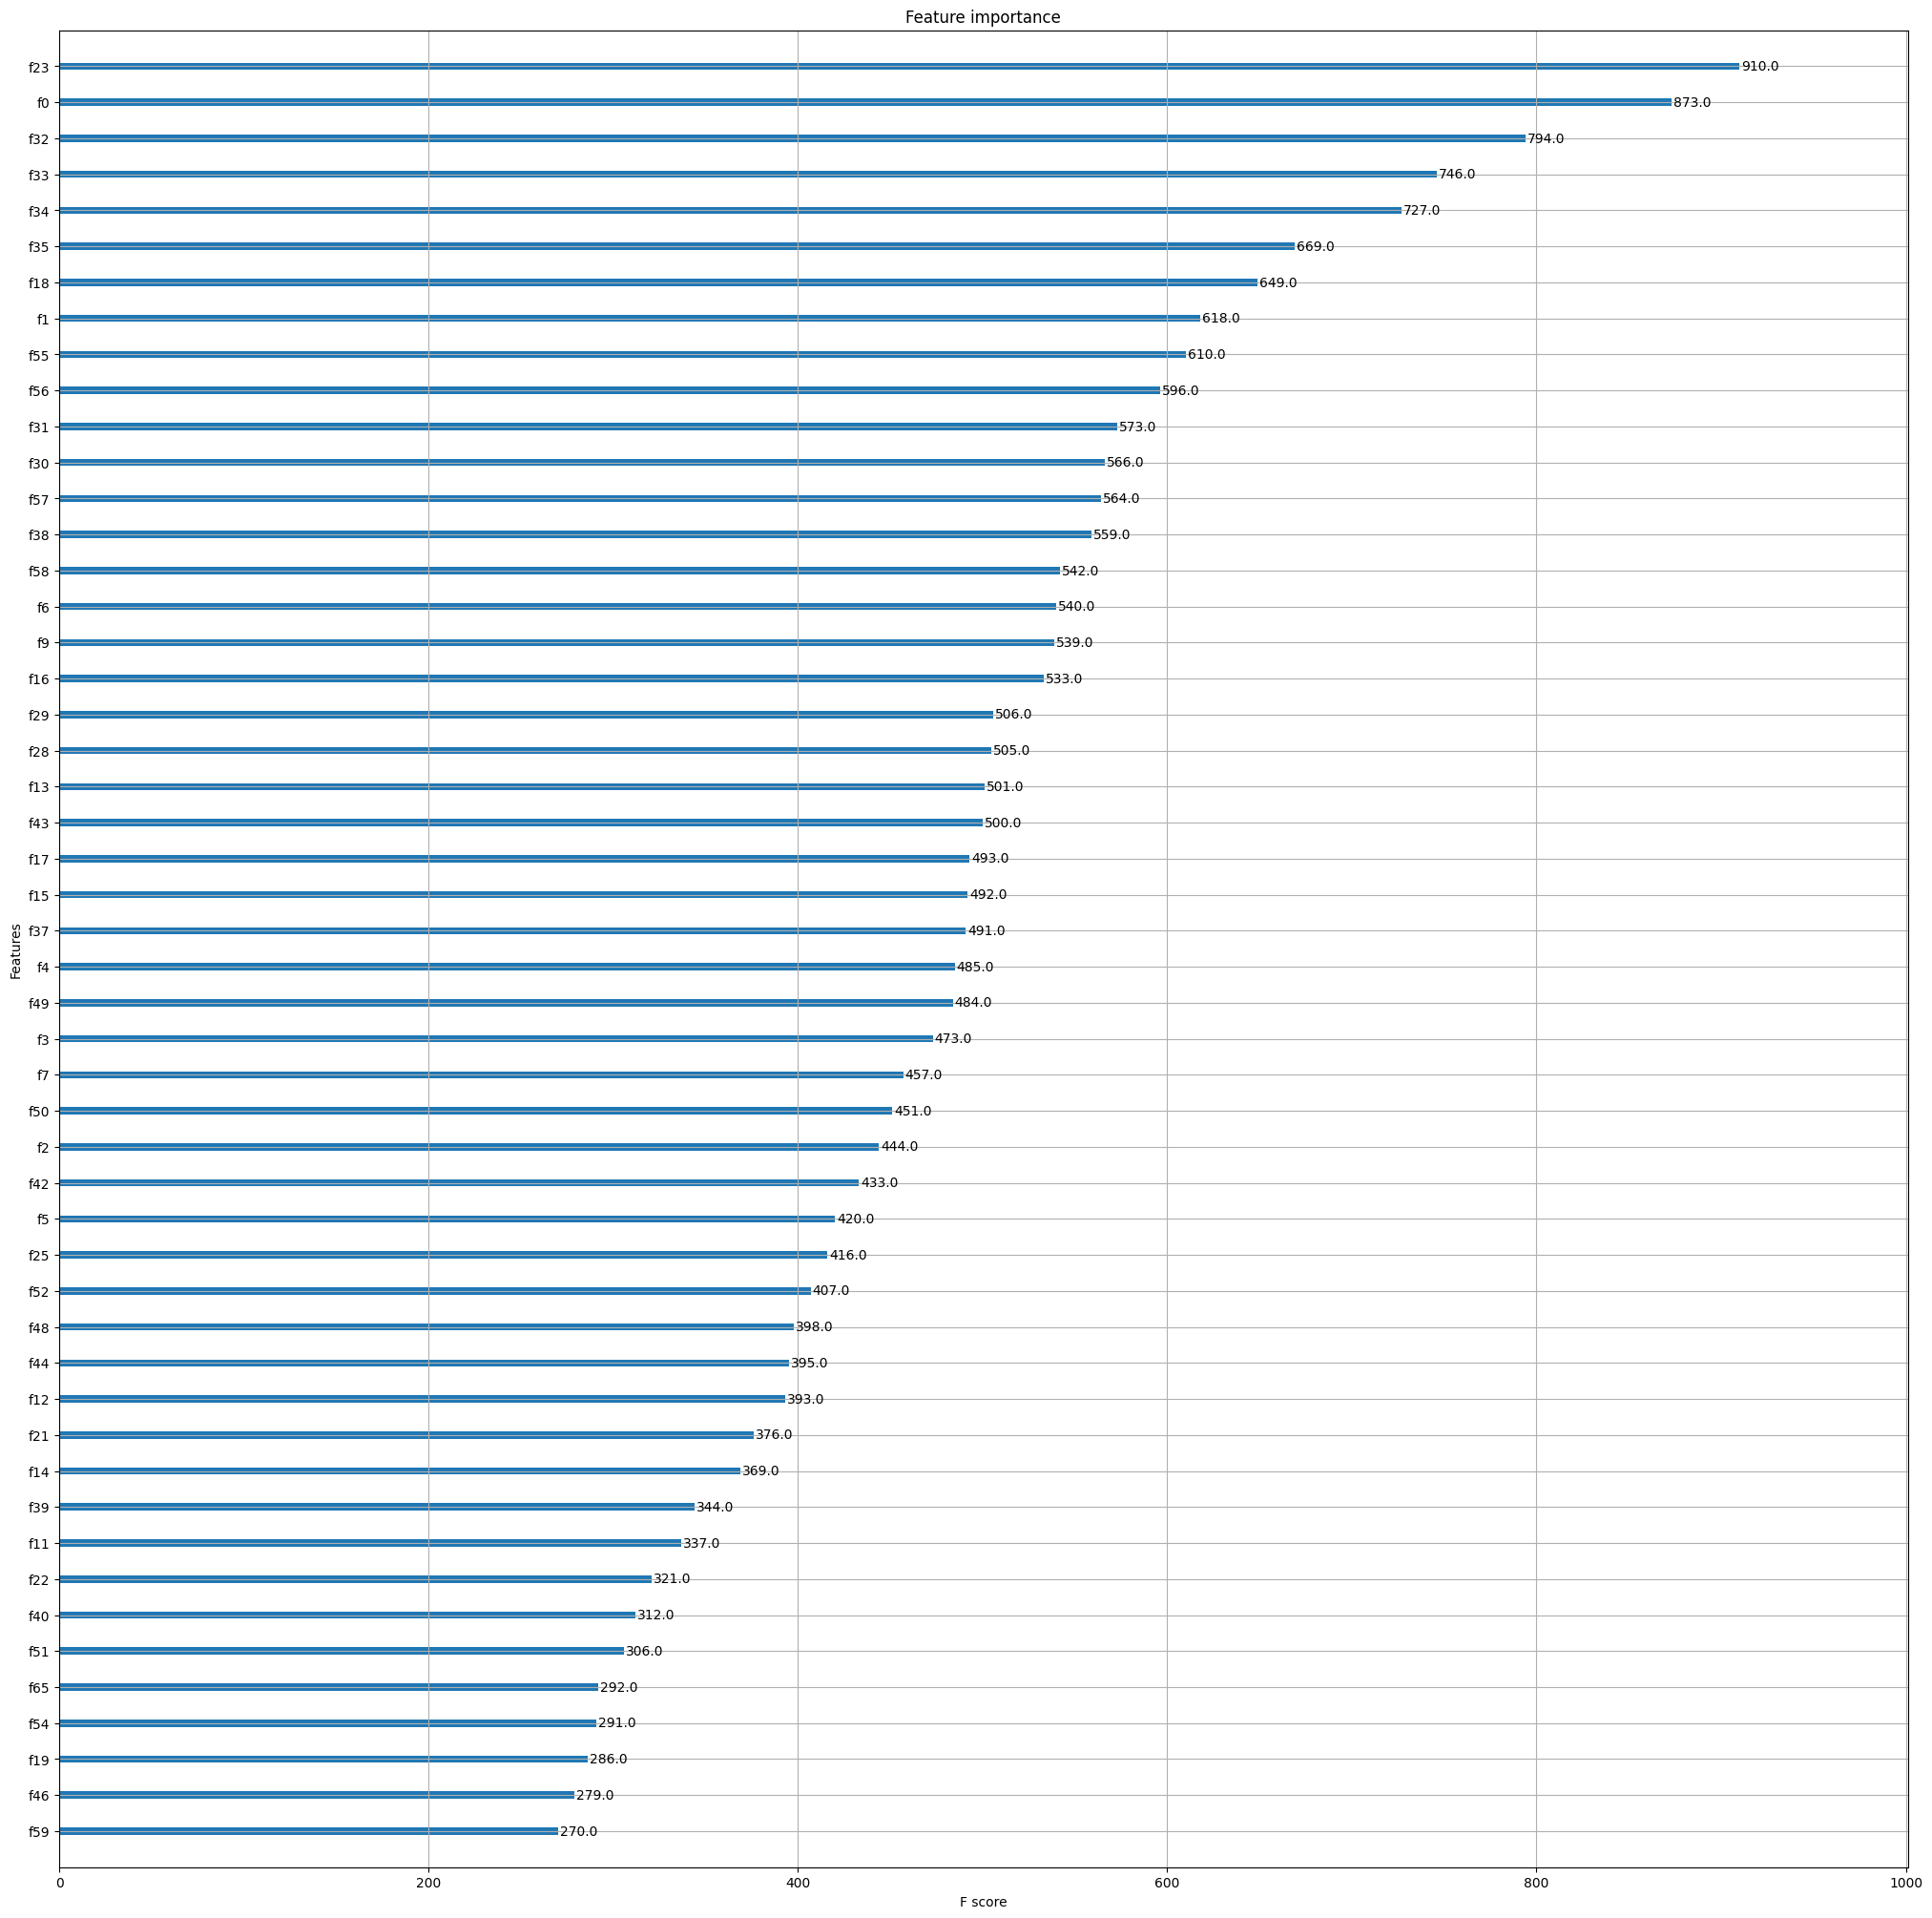

In [11]:
#xgb.to_graphviz(bst2_retuned, num_trees=0, rankdir='LR')
import treeplot as tree

ax = tree.plot(bst2_retuned,  featnames=X_train2.columns, num_trees=0, plottype='vertical')
plt.show()

# Model Three (Wild Bird Labels switched off)

In [30]:
#Load M3
bst3 = xgb.Booster({'nthread': 4}) #init model
bst3.load_model('../model3/modelxgb3.model')
print("Successfully loaded the models.....")

Successfully loaded the models.....


In [24]:
#Load Train and Test Excel files
train_df3 = pd.read_excel("../model3/m3train_new.xlsx")
test_df3 = pd.read_excel("../model3/m3test_new.xlsx")
X_train3 = train_df3.iloc[:,3:] #Training
y_train3 = train_df3.iloc[:,2:3]

#Test 
X_test3 = test_df3.iloc[:,3:]
X_test_raw3 = test_df3.iloc[:,3:]
y_test3 = test_df3.iloc[:,2:3]
y_test_raw3 = test_df3.iloc[:,2:3]

print("Finished Loading data...")

Finished Loading data...


/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/homebrew/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



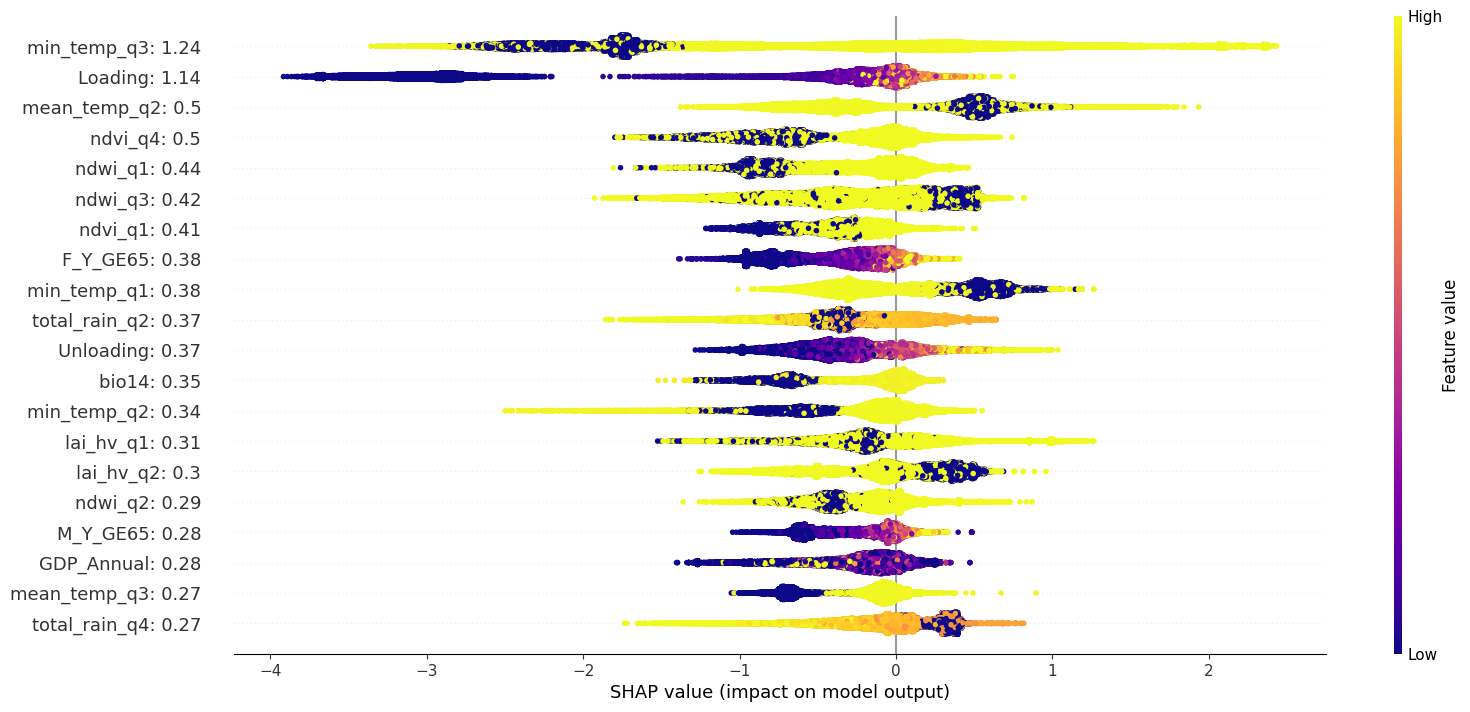

In [25]:
### Class Contribution
explainer = shap.TreeExplainer(bst3)
shap_values3x = explainer(X_train3)
shap_values3 = explainer.shap_values(X_train3)
#print(shap_values)
feature_names = [a + ": " + str(b) for a,b in zip(X_train3.columns, np.abs(shap_values3).mean(0).round(2))]
shap.summary_plot(shap_values3, 
                  features=X_train3, 
                #cmap = plt.get_cmap("summer"),
                  cmap = plt.get_cmap("plasma"),
                  feature_names=feature_names,
                  show=False
                )
plt.gcf().set_size_inches(20,7)
plt.show()

### Class Contribution

In [32]:
global_class_contribution(bst3, X_train3, "bst3")
print("\nDone Processing...\n")

Model Name.... bst3

Done Processing...




Done Processing...



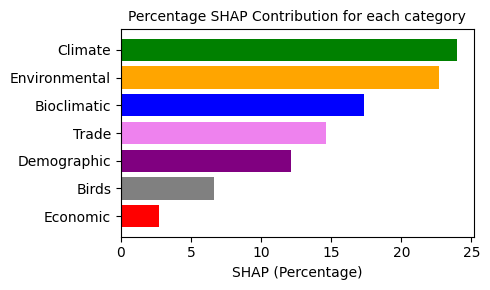

In [12]:
df = pd.read_excel("../model_graphs/model3_bargraph.xlsx")
x = df["Variables"]
y = df["Percentage"]
color=["green","orange",  "blue", "violet", "purple", "gray", "red"]
revcolor = color[::-1]
plt.figure(figsize=(5,3))
plt.title("Percentage SHAP Contribution for each category", fontsize = 10)
plt.xlabel("SHAP (Percentage)")
#plt.ylabel("Feature Category")
plt.barh(x,y, color=revcolor)
plt.tight_layout()
plt.savefig("../images/model3_shapCat.png", dpi=500)
print("\nDone Processing...\n")